# Librerías y detección de GPUs

In [ ]:
import numpy as np
from numba import cuda
import numba
import math
import string
import matplotlib.pyplot as plt
from skimage import data, io
import requests
from time import perf_counter

cuda.gpus
cuda.detect()
cuda.select_device(0)

Found 1 CUDA devices
id 0             b'Tesla T4'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 4
                              PCI Bus ID: 0
                                    UUID: GPU-4b6579a9-5126-3e40-218c-23ec2f2d2ac0
                                Watchdog: Disabled
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


<weakproxy at 0x7a9efe9f27a0 to Device at 0x7a9efe9cc880>

# Cantidad de SMs y Cores

In [ ]:
cc_cores_per_SM_dict = {  (2,0) : 32,  (2,1) : 48, (3,0) : 192, (3,5) : 192, (3,7) : 192, (5,0) : 128, (5,2) : 128, (6,0) : 64, (6,1) : 128, (7,0) : 64, (7,5) : 64, (8,0) : 64, (8,6) : 128, (8,9) : 128, (9,0) : 128 }
device = cuda.get_current_device()
sms = getattr(device, "MULTIPROCESSOR_COUNT")
cc = device.compute_capability
cores_per_sm = cc_cores_per_SM_dict.get(cc)
num_cores = cores_per_sm * sms
print("GPU compute capability: ", cc)
print("Número de SM: ", sms)
print("Número de cores: ", num_cores)

GPU compute capability:  (7, 5)
Número de SM:  40
Número de cores:  2560


# Atributos relevantes del GPU

In [ ]:
from numba.cuda.cudadrv import enums

device = cuda.get_current_device()
attribs = [name.replace("CU_DEVICE_ATTRIBUTE_", "") for name in dir(enums) if name.startswith("CU_DEVICE_ATTRIBUTE_")]
for attr in attribs:
    print(attr, "=", getattr(device, attr))

ASYNC_ENGINE_COUNT = 3
CAN_MAP_HOST_MEMORY = 1
CAN_USE_HOST_POINTER_FOR_REGISTERED_MEM = 1
CLOCK_RATE = 1590000
COMPUTE_CAPABILITY_MAJOR = 7
COMPUTE_CAPABILITY_MINOR = 5
COMPUTE_MODE = 0
COMPUTE_PREEMPTION_SUPPORTED = 1
CONCURRENT_KERNELS = 1
CONCURRENT_MANAGED_ACCESS = 1
COOPERATIVE_LAUNCH = 1
COOPERATIVE_MULTI_DEVICE_LAUNCH = 1
ECC_ENABLED = 1
GLOBAL_L1_CACHE_SUPPORTED = 1
GLOBAL_MEMORY_BUS_WIDTH = 256
GPU_OVERLAP = 1
HOST_NATIVE_ATOMIC_SUPPORTED = 0
INTEGRATED = 0
IS_MULTI_GPU_BOARD = 0
KERNEL_EXEC_TIMEOUT = 0
L2_CACHE_SIZE = 4194304
LOCAL_L1_CACHE_SUPPORTED = 1
MANAGED_MEMORY = 1
MAX_BLOCK_DIM_X = 1024
MAX_BLOCK_DIM_Y = 1024
MAX_BLOCK_DIM_Z = 64
MAX_GRID_DIM_X = 2147483647
MAX_GRID_DIM_Y = 65535
MAX_GRID_DIM_Z = 65535
MAX_MAX_TEXTURE_2D_MIPMAPPED_HEIGHT = 32768
MAX_PITCH = 2147483647
MAX_REGISTERS_PER_BLOCK = 65536
MAX_REGISTERS_PER_MULTIPROCESSOR = 65536
MAX_SHARED_MEMORY_PER_BLOCK = 49152
MAX_SHARED_MEMORY_PER_BLOCK_OPTIN = 65536
MAX_SHARED_MEMORY_PER_MULTIPROCESSOR = 65536
MAX_S

# Lanzamiento de un Kernel simplista para un Vector Ad-hoc

In [ ]:
@cuda.jit
def a_kernel(my_array):
  """
  Aquí iría el código de mi kernel
  """
  pass

my_array = np.ones(320)
# hilos por bloque debe estar en función del warp size
threads_per_block = 32
# número de bloques en la rejilla
my_grid  = my_array.size // threads_per_block
a_kernel[my_grid, threads_per_block](my_array)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


# Posición de los Hilos relativa a los Datos para un Vector Genérico y copiar vectores al Device

In [ ]:
@cuda.jit
def multiplier_kernel(my_array, structure):
  position = cuda.threadIdx.x + cuda.blockIdx.x*cuda.blockDim.x
  if position < my_array.size:
    my_array[position] *= 2
    structure[position][0] = position
    structure[position][1] = cuda.threadIdx.x
    structure[position][2] = cuda.blockIdx.x
    structure[position][3] = cuda.blockDim.x

VECTOR_SIZE = 321
my_array = np.ones(VECTOR_SIZE)
# Copiar arreglo al device
device_array = cuda.device_array_like(my_array)

VARS_TO_DEBUG = 4;
structure = np.zeros(shape=(VECTOR_SIZE, VARS_TO_DEBUG))

threads_per_block = 32

# número de bloques en la rejilla
my_grid = math.ceil(my_array.size / threads_per_block)
my_grid

multiplier_kernel[my_grid, threads_per_block](my_array, structure)
print(my_array)
for step in structure:
  print(step)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[ 0.  0.  0. 32.]
[ 1.

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


# Cálculo rápido de la posición del hilo & Debugging de un programa en CUDA

In [ ]:
@cuda.jit
def multiplier_kernel(my_array, structure):
  position = cuda.threadIdx.x + cuda.blockIdx.x*cuda.blockDim.x
  if position < my_array.size:
    my_array[position] *= 2
    structure[position][0] = position
    structure[position][1] = cuda.threadIdx.x
    structure[position][2] = cuda.blockIdx.x
    structure[position][3] = cuda.blockDim.x

my_array = np.ones(321)
device_array = cuda.device_array_like(my_array)
structure = np.zeros(shape=(321, 4))
threads_per_block = 32
my_grid = math.ceil(my_array.size / threads_per_block)
multiplier_kernel[my_grid, threads_per_block](my_array, structure)
print(my_array)
for step in structure:
  print(step)


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]
[ 0.  0.  0. 32.]
[ 1.

# Suma de vectores optimizada con copias al device

In [ ]:
@cuda.jit
def sum_kernel(a, b, c):
  position = cuda.grid(1)
  if position < a.size:
    c[position] = a[position] + b[position]

VECTOR_SIZE = 321
a = np.ones(VECTOR_SIZE)
b = np.ones(VECTOR_SIZE)
c = np.zeros(VECTOR_SIZE)

# Copiando al device
device_a = cuda.to_device(a)
device_b = cuda.to_device(b)
#device_c = cuda.device_array_like(c)
device_c = cuda.device_array(VECTOR_SIZE)


threads_per_block = 32
my_grid = math.ceil(a.size / threads_per_block)
sum_kernel[my_grid, threads_per_block](device_a, device_b, device_c)

print(device_c.copy_to_host())

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2.]


# Suma de matrices con grid de una sola dimensión
## Rejilla asociada a los renglones

In [ ]:
np.set_printoptions(suppress=True)

@cuda.jit
def addition_matrix_kernel(a, b, c):
  i = cuda.grid(1)
  if i < a.shape[0]:
    for j in range(a.shape[1]):
      c[i][j] = a[i][j] + b[i][j]

ROWS = 64
COLUMNS = 128
host_a = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_b = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_c = np.zeros(shape=(ROWS, COLUMNS))

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array_like(host_c)

threads_per_block = 32
my_grid = math.ceil(ROWS / threads_per_block)
print(my_grid, threads_per_block)
addition_matrix_kernel[my_grid, threads_per_block](dev_a, dev_b, dev_c)
print(dev_c.copy_to_host())

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


2 32
[[    0.     2.     4. ...   250.   252.   254.]
 [  256.   258.   260. ...   506.   508.   510.]
 [  512.   514.   516. ...   762.   764.   766.]
 ...
 [15616. 15618. 15620. ... 15866. 15868. 15870.]
 [15872. 15874. 15876. ... 16122. 16124. 16126.]
 [16128. 16130. 16132. ... 16378. 16380. 16382.]]


# Suma de matrices con grid de una sola dimensión
## Rejilla asociada a las columnas

In [ ]:
np.set_printoptions(suppress=True)

@cuda.jit
def addition_matrix_kernel(a, b, c):
  j = cuda.grid(1)
  if j < a.shape[1]:
    for i in range(a.shape[0]):
      c[i][j] = a[i][j] + b[i][j]

ROWS = 64
COLUMNS = 129
host_a = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_b = np.arange(ROWS*COLUMNS).reshape((ROWS, COLUMNS))
host_c = np.zeros(shape=(ROWS, COLUMNS))

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array_like(host_c)

threads_per_block = 32
my_grid = math.ceil(COLUMNS / threads_per_block)
print(my_grid, threads_per_block)
addition_matrix_kernel[my_grid, threads_per_block](dev_a, dev_b, dev_c)
print(dev_c.copy_to_host())

5 32


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[[    0.     2.     4. ...   252.   254.   256.]
 [  258.   260.   262. ...   510.   512.   514.]
 [  516.   518.   520. ...   768.   770.   772.]
 ...
 [15738. 15740. 15742. ... 15990. 15992. 15994.]
 [15996. 15998. 16000. ... 16248. 16250. 16252.]
 [16254. 16256. 16258. ... 16506. 16508. 16510.]]


# Suma de Matrices

In [ ]:
import math
import numpy as np
from numba import cuda

@cuda.jit
def matrix_addition(A, B, C):
  row = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  col = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
  #row, col = cuda.grid(2)
  if row < C.shape[0] and col < C.shape[1]:
    C[row][col] = A[row][col] + B[row][col]

ROWS = 320
COLUMNS = 1280
host_a = np.full((ROWS, COLUMNS), 2, float)
host_b = np.full((ROWS, COLUMNS), 4, float)

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array((ROWS, COLUMNS))

# 16 * 32 = 512 threads
threads_per_block = (16, 32)
blocks_x = math.ceil(ROWS / threads_per_block[0])
blocks_y = math.ceil(COLUMNS / threads_per_block[1])
grid = (blocks_x, blocks_y)
print(grid)
matrix_addition[grid, threads_per_block](dev_a, dev_b, dev_c)

print(dev_c.copy_to_host())

(20, 40)
[[6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 ...
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]
 [6. 6. 6. ... 6. 6. 6.]]


# Multiplicación de Matrices

In [ ]:
import math
import numpy as np
from numba import cuda

@cuda.jit
def matrix_multiplication(A, B, C):
  row, col = cuda.grid(2)
  if row < C.shape[0] and col < C.shape[1]:
    sum = 0
    for k in range(A.shape[1]):
      sum += A[row][k] * B[k][col]
    C[row][col] = sum

host_a = np.full((32, 12), 2, float)
host_b = np.full((12, 48), 4, float)
host_c = np.full((32, 48), 0, float)

dev_a = cuda.to_device(host_a)
dev_b = cuda.to_device(host_b)
dev_c = cuda.device_array((32, 48))

threads_per_block = (16, 32)
blocks_x = math.ceil(host_c.shape[0] / threads_per_block[0])
blocks_y = math.ceil(host_c.shape[1] / threads_per_block[1])
grid = (blocks_x, blocks_y)
print(grid)
matrix_multiplication[grid, threads_per_block](dev_a, dev_b, dev_c)

print(dev_c.copy_to_host())

(2, 2)
[[96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 ...
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]
 [96. 96. 96. ... 96. 96. 96.]]


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


# Aplicación de filtro a Imagen

1.0 255.0 [[ 18.  17.  17. ... 126. 126. 123.]
 [ 21.  21.  22. ... 128. 127. 124.]
 [ 25.  26.  27. ... 130. 129. 125.]
 ...
 [ 67.  56.  51. ...  68.  65.  63.]
 [ 67.  61.  55. ...  76.  73.  69.]
 [ 69.  65.  64. ...  75.  80.  78.]]


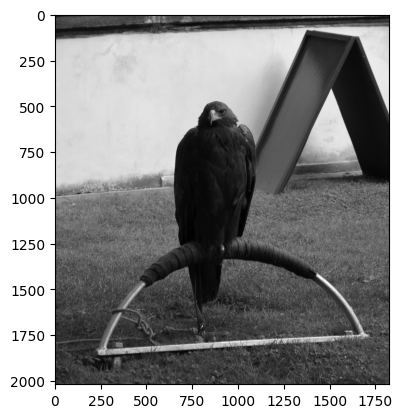

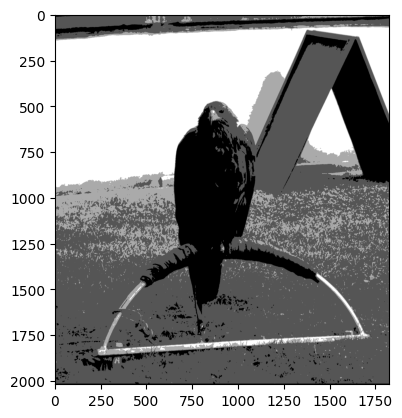

In [ ]:
from numba import cuda
import matplotlib.pyplot as plt
from skimage import data, io
import math
import numpy as np

@cuda.jit
def conv(pixels, output, size):
    row, col = cuda.grid(2)
    if (row + 2) < size[0] and (col + 2) < size[1] and row > 2 and col > 2:
      divisor = 75
      sum = pixels[row-2][col-1]/divisor + pixels[row-2][col]/divisor + pixels[row-2][col+1]/divisor + \
            pixels[row-1][col-1]/divisor + pixels[row-1][col]/divisor + pixels[row-1][col+1]/divisor + \
            pixels[row-0][col-1]/divisor + pixels[row-0][col]/divisor + pixels[row-0][col+1]/divisor + \
            pixels[row+1][col-1]/divisor + pixels[row+1][col]/divisor + pixels[row+1][col+1]/divisor + \
            pixels[row+2][col-1]/divisor + pixels[row+2][col]/divisor + pixels[row+2][col+1]/divisor
      output[row][col] = round(sum/15)


#eagle = data.eagle().astype(np.float32)
eagle = io.imread("eagle.png").astype(np.float32)
print(eagle.min(), eagle.max(), eagle)
plt.imshow(eagle, cmap="gray")
plt.show()

##(2019, 1826)
host_pixels = eagle
device_pixels = cuda.to_device(host_pixels)
device_output = cuda.device_array(host_pixels.shape)


threads_per_block = (16, 16)
blocks_x = math.ceil(eagle.shape[0] / threads_per_block[0])
blocks_y = math.ceil(eagle.shape[1] / threads_per_block[1])
grid = (blocks_x, blocks_y)

conv[grid, threads_per_block](device_pixels, device_output, eagle.shape)
plt.imshow(device_output.copy_to_host(), cmap="gray")
plt.show()


# Reducción de Imagen

(760, 760)


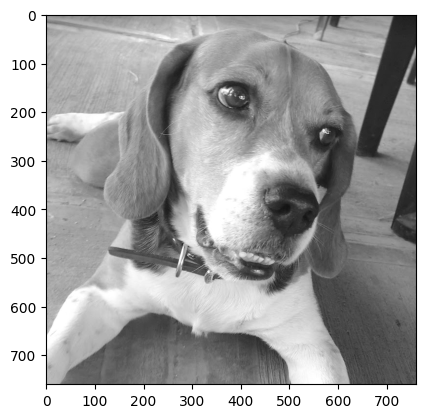

(24, 24)
(24, 24)


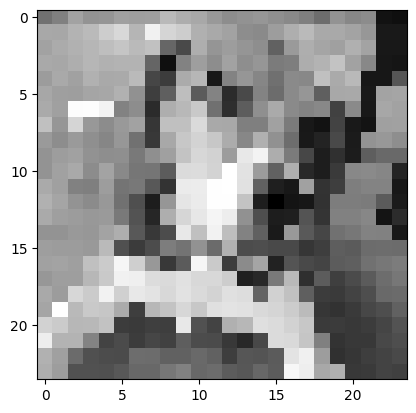

In [ ]:
from numba import cuda
import matplotlib.pyplot as plt
from skimage import data, io
import math
import numpy as np

@cuda.jit
def pixeled(input, output):
    x, y = cuda.grid(2)
    if (x + 1) < input.shape[0] and (y + 1) < input.shape[1] and x > 1 and y > 1:
        final_x = int((x / input.shape[0]) * output.shape[0])
        final_y = int((y / input.shape[1]) * output.shape[1])
        sum = input[x-1][y-1] + input[x][y-1] + input[x+1][y-1] + \
              input[x-1][y]   + input[x][y]   + input[x+1][y] + \
              input[x-1][y+1] + input[x][y+1] + input[x+1][y+1]
        output[final_x][final_y] = sum // 9

dog = io.imread("dante.png").astype(np.float32)
print(dog.shape)
plt.imshow(dog, cmap="gray")
plt.show()

host_pixels_input = dog
device_pixels_input = cuda.to_device(host_pixels_input)

threads_per_block = (32, 32)
grid = (math.ceil(host_pixels_input.shape[0] / threads_per_block[0]),
        math.ceil(host_pixels_input.shape[1] / threads_per_block[1]))

print(grid)
device_pixels_output = cuda.device_array(grid)
pixeled[grid, threads_per_block](device_pixels_input, device_pixels_output)
new_image = device_pixels_output.copy_to_host()
print(new_image.shape)
plt.imshow(new_image, cmap="gray")
plt.show()


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Cáculo de Histograma

## De texto a arreglos de caracteres

In [ ]:
def texto_a_arreglo(x):
  """ Convertir un texto cualquiera a un arreglo de caracteres (integers) equivalente """
  return np.frombuffer(bytes(x, "utf-8"), dtype=np.uint8)

texto = "Hola a todos!" + string.ascii_lowercase*2 + string.ascii_uppercase*3
print(texto)

caracteres = texto_a_arreglo(texto)

print(len(texto), caracteres.size, caracteres)

Hola a todos!abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZABCDEFGHIJKLMNOPQRSTUVWXYZABCDEFGHIJKLMNOPQRSTUVWXYZ
143 143 [ 72 111 108  97  32  97  32 116 111 100 111 115  33  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90]


# Extracción de corpus relativamente grande

In [ ]:
# Obras de William Shakespeare descargadas del proyecto Gutenberg
url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
respuesta = requests.get(url).text
caracteres = texto_a_arreglo(respuesta*100)
print(caracteres)

[239 187 191 ...  10  13  10]


## Cálculo de histograma en CPU (host)

Tiempo: 888.334989143 1939.656689223 1051.32170008
Tiempo: 1939.656977858 1947.067826892 7.410849034000194
[       0        0        0        0        0        0        0        0
        0      400 19639000        0        0 19639000        0        0
        0        0        0        0        0        0        0        0
        0        0        0        0        0        0        0        0
 83229500   780600        0      100      200      100     4800      100
    23400    23400     1800        0  9472100   390700  9138400      600
    15500    31000    18100    10800    15700     9800    14700     8100
    14900     9200   342700  1292000        0        0        0  1139600
        0  4353800  1318900  1788600  1281100  3407700  1084400   996900
  1671000  5167600   196100   545600  2048100  1422000  2351300  2590100
  1039600   119100  2256200  2959600  3829000  1153100   313700  1668800
    33800   716100    54800   425600        0   425400        0   970200
        0 2686510

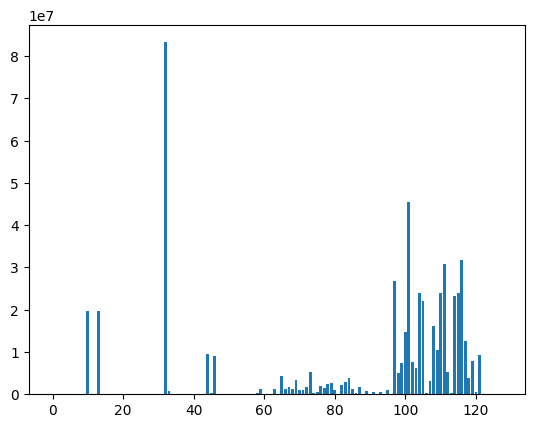

In [ ]:
def histograma_en_cpu(caracteres, num_barras):
  """ Cálculo de histroama en CPU/host """
  histograma = np.zeros(num_barras, dtype=np.int64)
  for caracter in caracteres:
    if caracter < 128:
      histograma[caracter] += 1
  return histograma


inicio = perf_counter()
histograma = histograma_en_cpu(caracteres, 128)
fin = perf_counter()
print("Tiempo:", inicio, fin, fin - inicio)

inicio = perf_counter()
np.histogram(caracteres, 128)
fin = perf_counter()
print("Tiempo:", inicio, fin, fin - inicio)


print(histograma)
print(np.histogram(caracteres, 128))

plt.bar(x=np.arange(128), height=histograma)
plt.show()

## Cálculo de histograma en GPU (device)

[239 187 191 ...  10  13  10]
Tiempo: 2556.435155698 2557.225414871 0.7902591729998676
Tiempo: 2557.225718155 2565.474670668 8.24895251299995
[       0        0        0        0        0        0        0        0
        0      400 19639000        0        0 19639000        0        0
        0        0        0        0        0        0        0        0
        0        0        0        0        0        0        0        0
 83229500   780600        0      100      200      100     4800      100
    23400    23400     1800        0  9472100   390700  9138400      600
    15500    31000    18100    10800    15700     9800    14700     8100
    14900     9200   342700  1292000        0        0        0  1139600
        0  4353800  1318900  1788600  1281100  3407700  1084400   996900
  1671000  5167600   196100   545600  2048100  1422000  2351300  2590100
  1039600   119100  2256200  2959600  3829000  1153100   313700  1668800
    33800   716100    54800   425600        0   425400 

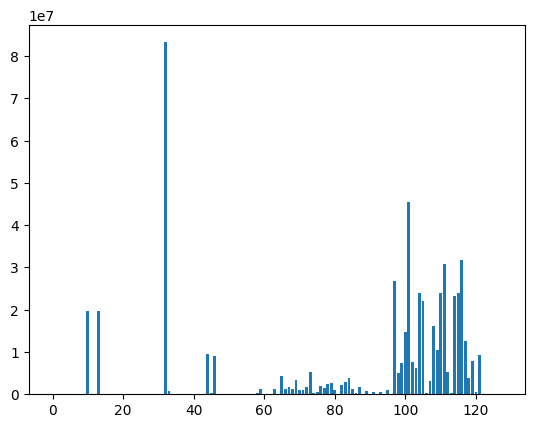

In [ ]:
@cuda.jit
def histograma_en_gpu(caracteres, histograma):
    posicion = cuda.grid(1)
    hilos_en_grid = cuda.gridsize(1)
    for i in range(posicion, caracteres.size, hilos_en_grid):
        if caracteres[i] < 128:
          #histograma[caracteres[i]] += 1
          cuda.atomic.add(histograma, caracteres[i], 1)

hilos_por_bloque = 128
bloques = 240

url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
respuesta = requests.get(url).text
caracteres = texto_a_arreglo(respuesta*100)
print(caracteres)

inicio = perf_counter()
caracteres_gpu = cuda.to_device(caracteres)
histograma_gpu = cuda.to_device(np.zeros(128, dtype=np.uint32))
histograma_en_gpu[bloques, hilos_por_bloque](caracteres_gpu, histograma_gpu)
histograma_cpu = histograma_gpu.copy_to_host()
fin = perf_counter()
print("Tiempo:", inicio, fin, fin - inicio)

inicio = perf_counter()
np.histogram(caracteres, 128)
fin = perf_counter()
print("Tiempo:", inicio, fin, fin - inicio)

print(histograma_cpu)
plt.bar(x=np.arange(128), height=histograma_cpu)
plt.show()

#print(histograma)
#plt.bar(x=np.arange(128), height=histograma)
#plt.show()

#print(histograma.sum(), histograma_cpu.sum())


# División del trabajo

In [ ]:
@cuda.jit
def histograma_en_gpu(caracteres, histograma):
    posicion = cuda.grid(1)
    hilos_en_grid = cuda.gridsize(1)
    for i in range(posicion, caracteres.size, hilos_en_grid):
        if caracteres[i] < 128:
          #histograma[caracteres[i]] += 1
          cuda.atomic.add(histograma, caracteres[i], 1)


url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"
respuesta = requests.get(url).text
caracteres = texto_a_arreglo(respuesta*100)
print(caracteres)

hilos_por_bloque = 128
bloques = 240

inicio = perf_counter()
caracteres_gpu = cuda.to_device(caracteres)
histograma_gpu = cuda.to_device(np.zeros(128, dtype=np.uint32))
histograma_en_gpu[bloques, hilos_por_bloque](caracteres_gpu, histograma_gpu)
histograma_cpu = histograma_gpu.copy_to_host()
fin = perf_counter()
print("Tiempo:", inicio, fin, fin - inicio)



inicio = perf_counter()
mitades = np.split(caracteres, [caracteres.size//2])
caracteres = mitades[0]
caracteres_gpu = cuda.to_device(caracteres)
histograma_gpu = cuda.to_device(np.zeros(128, dtype=np.uint32))
histograma_en_gpu[bloques, hilos_por_bloque](caracteres_gpu, histograma_gpu)
histograma_cpu_a = histograma_gpu.copy_to_host()

caracteres = mitades[1]
caracteres_gpu = cuda.to_device(caracteres)
histograma_gpu = cuda.to_device(np.zeros(128, dtype=np.uint32))
histograma_en_gpu[bloques, hilos_por_bloque](caracteres_gpu, histograma_gpu)
histograma_cpu_b = histograma_gpu.copy_to_host()
fin = perf_counter()
histograma_completo = histograma_cpu_a + histograma_cpu_b
print("Tiempo:", inicio, fin, fin - inicio)
print(histograma_cpu.sum(), histograma_completo.sum())

[239 187 191 ...  10  13  10]
Tiempo: 2510.10791117 2510.919149383 0.8112382129997968
Tiempo: 2510.919468366 2511.441970419 0.522502053000153
554319000 554319000
